# Data Preparation

In [1]:
import torch
from Data.quantum_dataset import QuantumDataset

torch.cuda.empty_cache()
potential_type = 'all'
dset = QuantumDataset(potential_type,memory=True)
file_labels = dset.get_labels()

HO_gen2_0010.h5
calculated_energy: (5000, 1)
cx: (5000, 1)
cy: (5000, 1)
kx: (5000, 1)
ky: (5000, 1)
potential: (5000, 1, 256, 256)
psi: (5000, 1, 256, 256)
theoretical_energy: (5000, 1)

IW_gen2_0010.h5
calculated_energy: (5000, 1)
cx: (5000, 1)
cy: (5000, 1)
eigenvalues: (5000, 5)
potential: (5000, 1, 256, 256)
theoretical_energy: (5000, 1)
wavefunction: (5000, 1, 256, 256)
wx: (5000, 1)
wy: (5000, 1)

NG_gen2b_0000.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
parameters: (5000, 10)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)

RND_0011.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)

RND_KE_gen2_0010.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
kinetic_energy: (5000, 1)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)



Indexing:   0%|          | 0/5 [00:00<?, ?it/s]

Loading data into memory


Loading files to memory:   0%|          | 0/5 [00:00<?, ?it/s]

## Split Data

In [2]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

seed = 12

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_generator = torch.Generator()
train_generator.manual_seed(seed)

val_generator = torch.Generator()
val_generator.manual_seed(seed)

test_generator = torch.Generator()
test_generator.manual_seed(seed)

train_dataset, test_dataset = train_test_split(dset, test_size=0.2, shuffle=True,random_state=seed)
train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.2, shuffle=True,random_state=seed)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,generator=train_generator)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True,generator=val_generator)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True,generator=test_generator)

# Predict Wavefunction

## Train Model

In [3]:
from torch import nn
from tqdm.notebook import tqdm

def wavefunction_test(model:nn.Module,
                      dataloader:DataLoader,
                      wavefunction_loss_fn:nn.Module,
                      energy_loss_fn:nn.Module,
                      validate:bool=False,
                      device:str='cuda',
                      verbose=False,
                      display=False)->tuple:
    """
    Testing loop for WavefunctionCNN
    :param model: Model used for testing
    :param dataloader: DataLoader for testing or validation
    :paam wavefunction_loss_fn: Wavefunction loss function for displaying accuracy
    :param energy_loss_fn: Energy loss function for testing
    :param validate: True if validation data is used for testing
    :param device: CPU or CUDA
    :param verbose: True to print loss per epoch
    :param display: True to display tqdm subbars
    :return: Tuple containing loss from loss_fn, L1Loss, and energy_loss_fn
    """
    model.eval()
    wavefunction_losses = []
    energy_losses = []

    test_type = 'Validation' if validate else 'Test'

    with (torch.inference_mode()):
        for data in tqdm(dataloader,unit='batches',desc=f'{test_type} Loop',leave=False,display=display):

            wavefunction = model(data['potential'].to(device))

            wavefunction_loss = wavefunction_loss_fn(wavefunction**2,data['wavefunction2'].to(device)).item()
            wavefunction_losses.append(wavefunction_loss)
            energy_loss = energy_loss_fn(data['potential'].to(device),wavefunction,data['energy'].to(device)).item()
            energy_losses.append(energy_loss)

        average_wavefunction_loss = sum(wavefunction_losses) / len(wavefunction_losses)
        average_energy_loss = sum(energy_losses) / len(energy_losses)
        if verbose or test_type == 'Test':
            tqdm.write(f'{test_type} Energy Loss: {average_energy_loss}\n{test_type} Wavefunction Loss: {average_wavefunction_loss}')
        return average_wavefunction_loss, average_energy_loss

In [4]:
from HelperFunctions.plot_loss import plot_loss
from torch.optim import Optimizer
def wavefunction_train(model:nn.Module,
                       epochs:int,
                       train_dataloader:DataLoader,
                       validation_dataloader:DataLoader,
                       optimizer:Optimizer,
                       wavefunction_loss_fn:nn.Module,
                       energy_loss_fn:nn.Module,
                       device:str='cuda',
                       verbose=False,
                       display=False)->None:
    """
    Training loop for WavefunctionCNN
    :param model: Model used for training
    :param epochs: Number of cycles
    :param train_dataloader: Dataloader for training
    :param validation_dataloader: Dataloader for validation
    :param optimizer: Optimizer for training
    :paam wavefunction_loss_fn: Wavefunction loss function for displaying accuracy
    :param energy_loss_fn: Energy loss function for training
    :param device: CPU or CUDA
    :param verbose: True to print loss per epoch
    :param display: True to display tqdm subbars
    :return: None
    """

    train_energy_loss_change = []
    train_wavefunction_loss_change = []
    val_energy_loss_change = []
    val_wavefunction_loss_change = []

    model = model.to(device)
    wavefunction_loss_fn = wavefunction_loss_fn.to(device)
    energy_loss_fn = energy_loss_fn.to(device)

    for epoch in tqdm(range(epochs),unit='epochs',desc='Training Model',position=0):
        model.train()
        wavefunction_losses = []
        energy_losses = []
        for data in tqdm(train_dataloader,unit='batches',desc='Training Loop',leave=False,position=1,display=display):
            optimizer.zero_grad()

            potential = data['potential'].to(device)
            wavefunction = model(potential)

            loss = energy_loss_fn(potential,wavefunction,data['energy'].to(device))
            energy_losses.append(loss.item())

            if torch.isnan(loss):
                print('Loss is NaN!')
                return None

            wavefunction_loss = wavefunction_loss_fn(wavefunction**2, data['wavefunction2'].to(device))
            wavefunction_losses.append(wavefunction_loss.item())

            loss.backward()

            for name, param in model.named_parameters():
                if torch.isnan(param.grad).any():
                    print(f'NaN gradient in {name}!')
                    return None
            optimizer.step()

        avg_wavefunction_loss = sum(wavefunction_losses) / len(wavefunction_losses)
        train_wavefunction_loss_change.append(avg_wavefunction_loss)
        avg_energy_loss = sum(energy_losses) / len(energy_losses)
        train_energy_loss_change.append(avg_energy_loss)
        result_text = f"""Epoch {epoch + 1}/{epochs}\nTrain Energy Loss: {avg_energy_loss}\nTrain Wavefunction Loss {avg_wavefunction_loss}"""
        if verbose:
            tqdm.write(result_text)
        val_wavefunction_loss,val_energy_loss = wavefunction_test(model,validation_dataloader,wavefunction_loss_fn,energy_loss_fn,validate=True,device=device,verbose=verbose,display=display)

        val_wavefunction_loss_change.append(val_wavefunction_loss)
        val_energy_loss_change.append(val_energy_loss)

    plot_loss(loss1=train_energy_loss_change,loss2=val_energy_loss_change,label1='Train Energy Loss',label2='Validation Energy Loss')
    plot_loss(loss1=train_wavefunction_loss_change,loss2=val_wavefunction_loss_change,label1='Train Wavefunction Loss',label2='Validation Wavefunction Loss')
    return None


## Loop

Training Model:   0%|          | 0/1 [00:00<?, ?epochs/s]

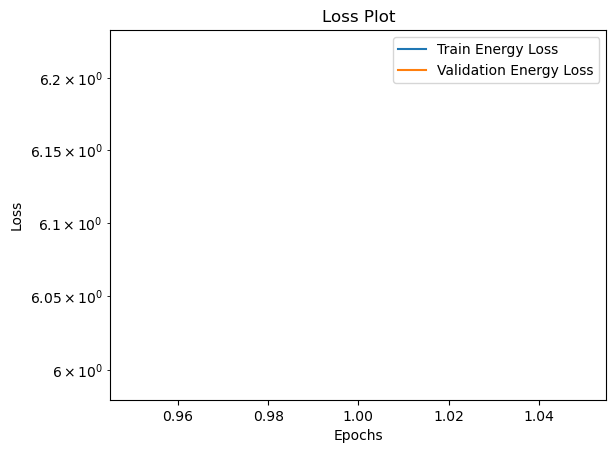

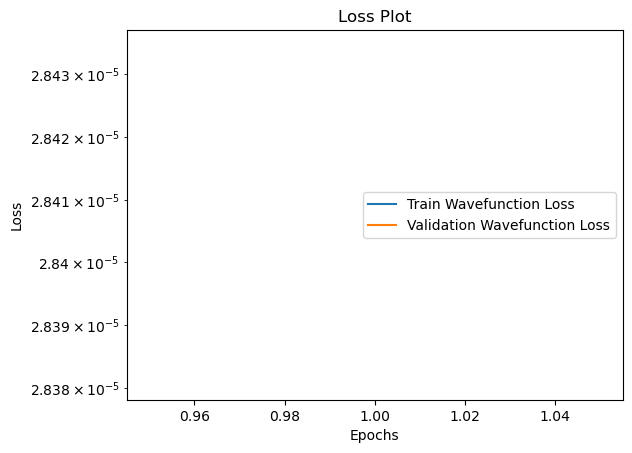

Test Energy Loss: 6.1494937864736245
Test Wavefunction Loss: 2.8408145825002945e-05


(2.8408145825002945e-05, 6.1494937864736245)

In [5]:
from wavefunction_unet import WavefunctionUNet
from energy_loss import EnergyLoss

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = WavefunctionUNet(channels=[16,32,64,128,256,512]).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

dx = 0.15625 #Constant determined in README.md
energy_loss_fn = EnergyLoss(alpha=1,gamma=0,dx=dx,loss_fn=nn.L1Loss())

epochs = 10

verbose = False
display = False

wavefunction_loss_fn = nn.L1Loss()

wavefunction_train(model,epochs,train_dataloader,validation_dataloader,optimizer,wavefunction_loss_fn,energy_loss_fn,device=device,verbose=verbose,display=display)
wavefunction_test(model,test_dataloader,wavefunction_loss_fn,energy_loss_fn,validate=False,device=device,verbose=verbose,display=display)

In [13]:
torch.save(model.state_dict(), '../Data/backup/w_model_state_dict.pt')

## Results

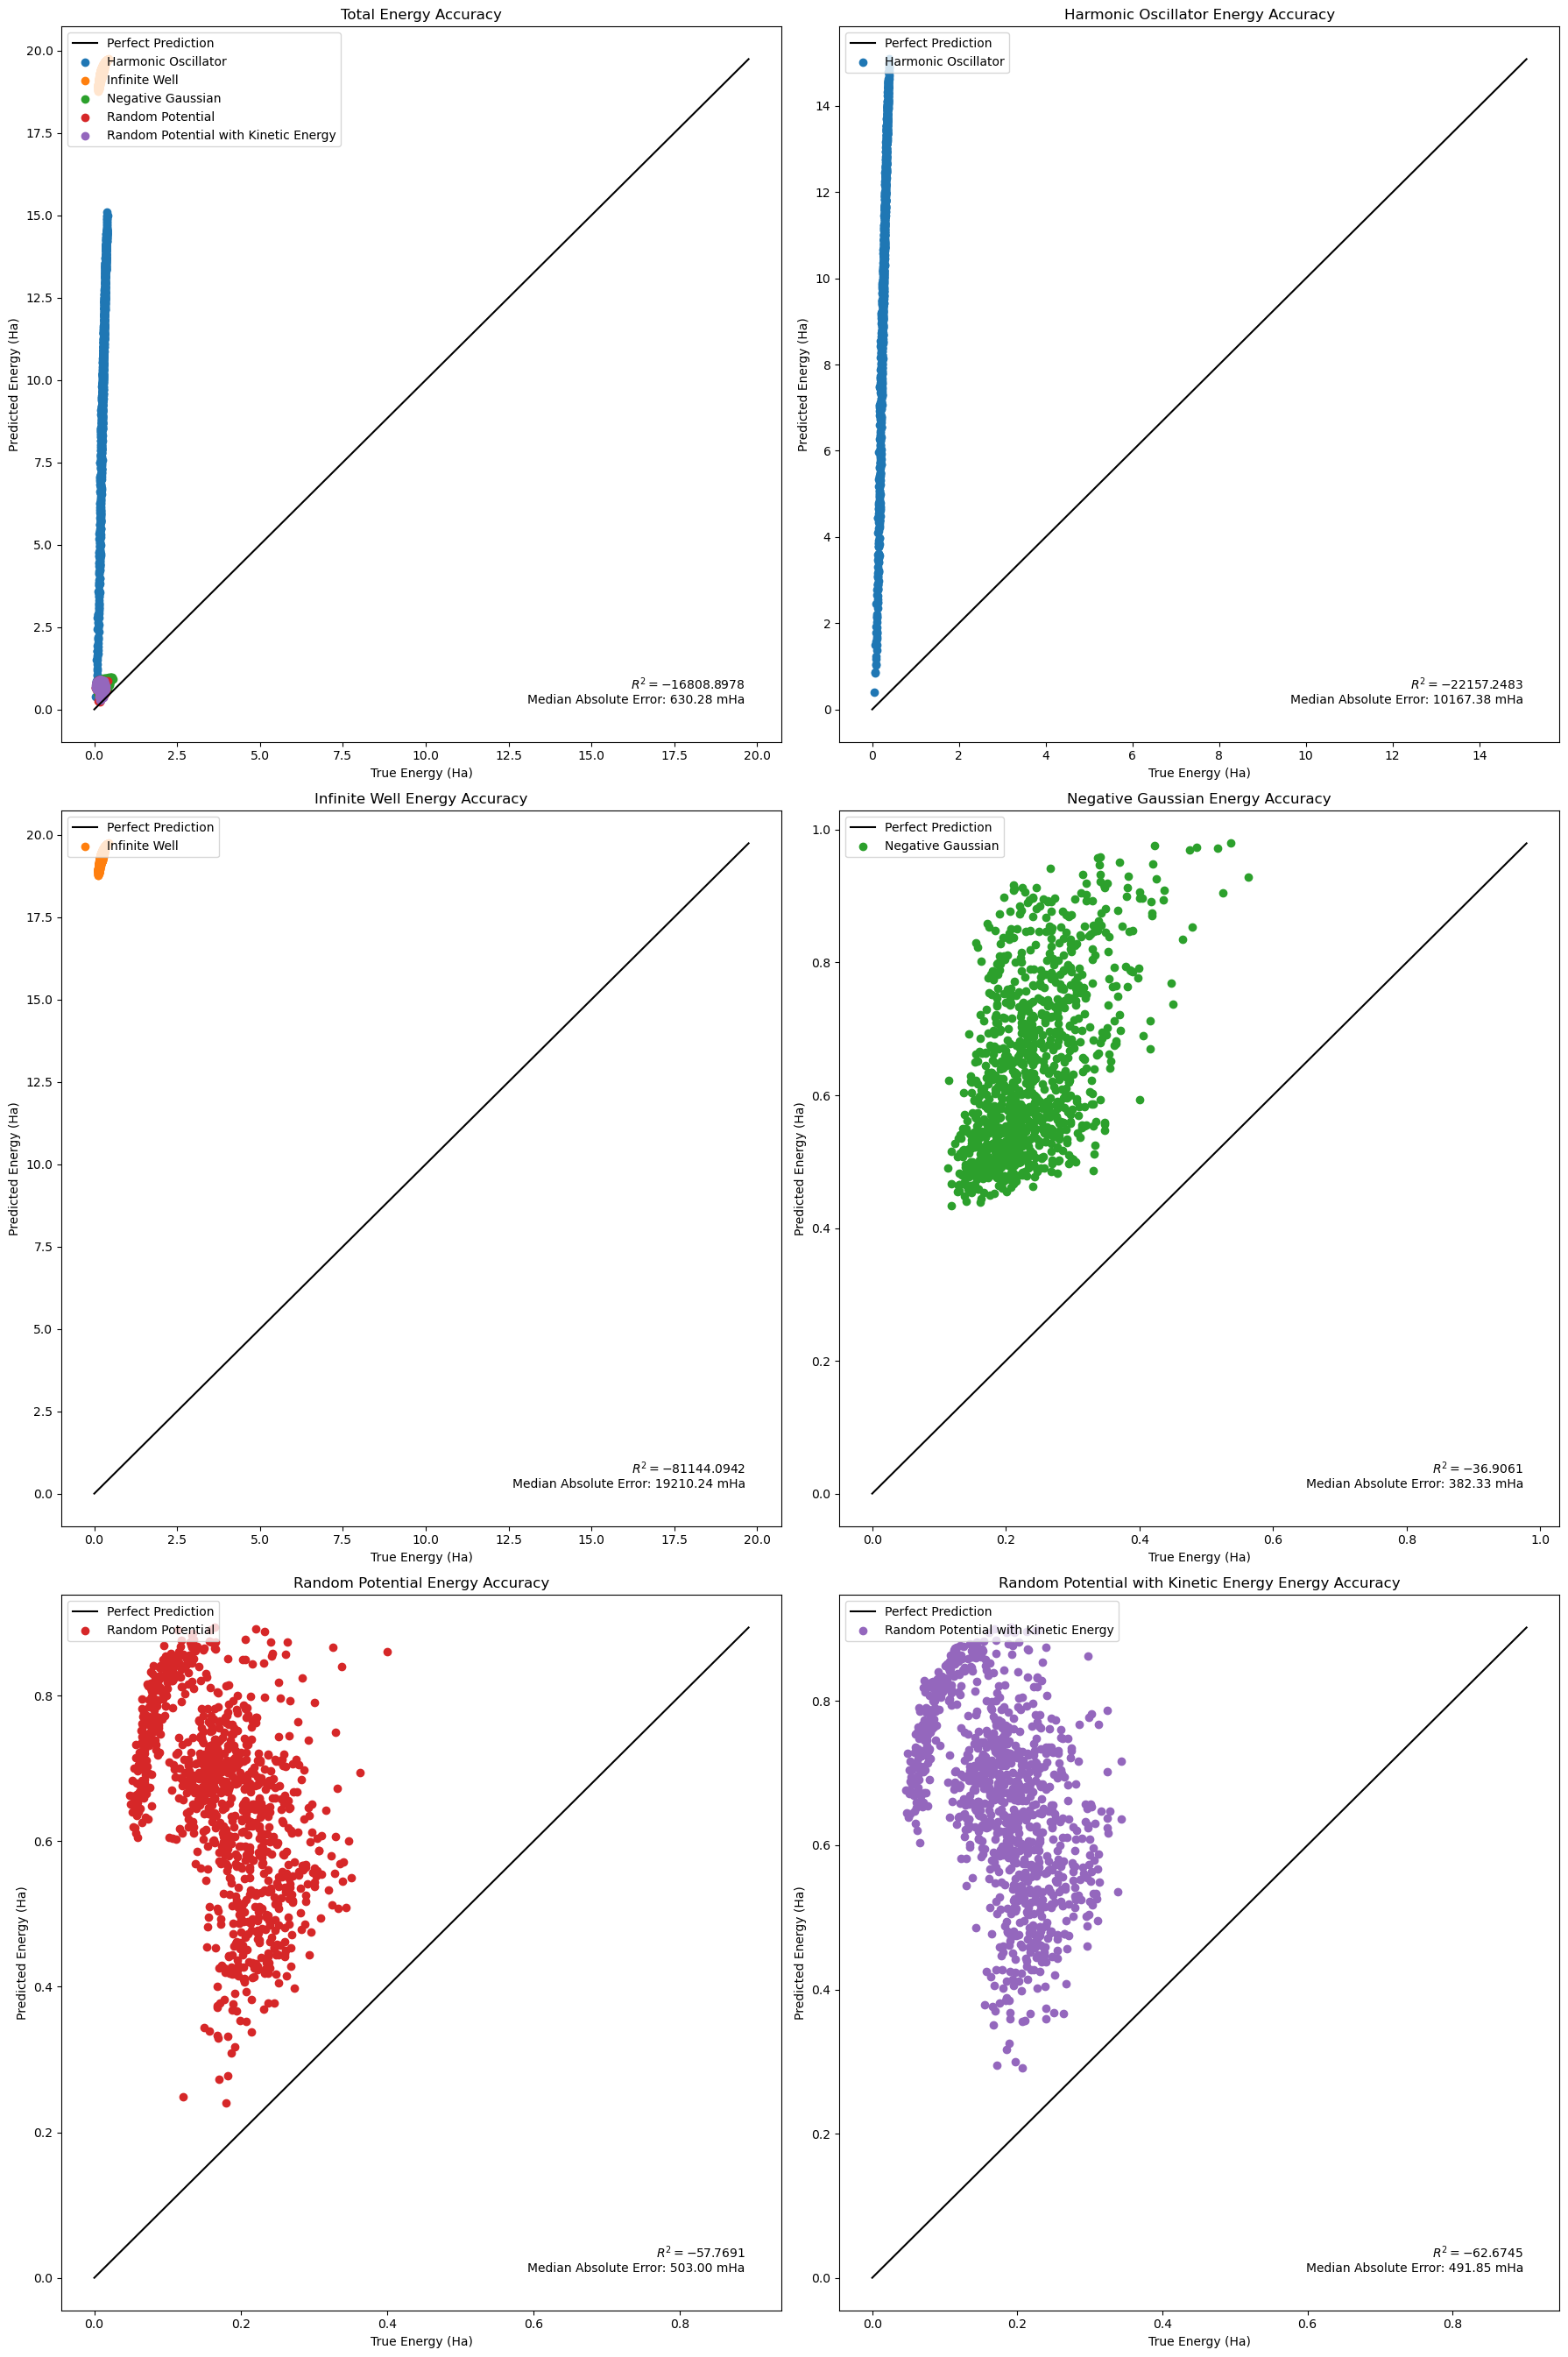

In [7]:
from HelperFunctions.plot_energy import plot_energy
presentation_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

E_true = []
E_pred = []
potential_indices = []

model.eval()
for i, data in enumerate(presentation_dataloader):
    potential = data['potential'].to(device)
    wavefunction = data['wavefunction2'].to(device)
    energy = data['energy']
    potential_index = data['potential_index']
    E_true.append(energy.item())
    potential_indices.append(potential_index.item())
    with torch.inference_mode():
        wavefunction_guess = model.forward(potential)
        energy_guess = energy_loss_fn.get_energy(potential,wavefunction_guess)
        E_pred.append(energy_guess.item())
plot_energy(E_pred,E_true,file_labels,potential_indices)

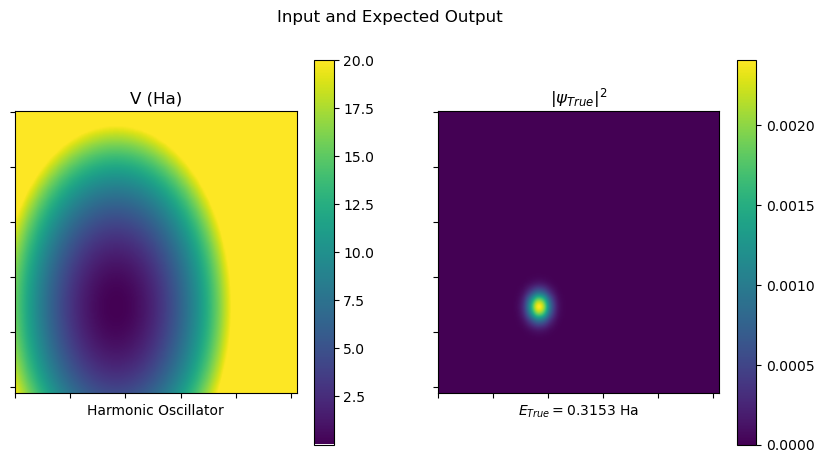

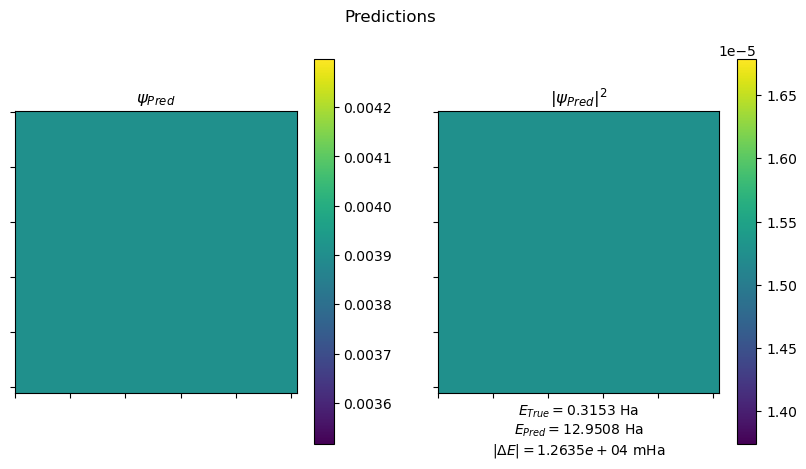

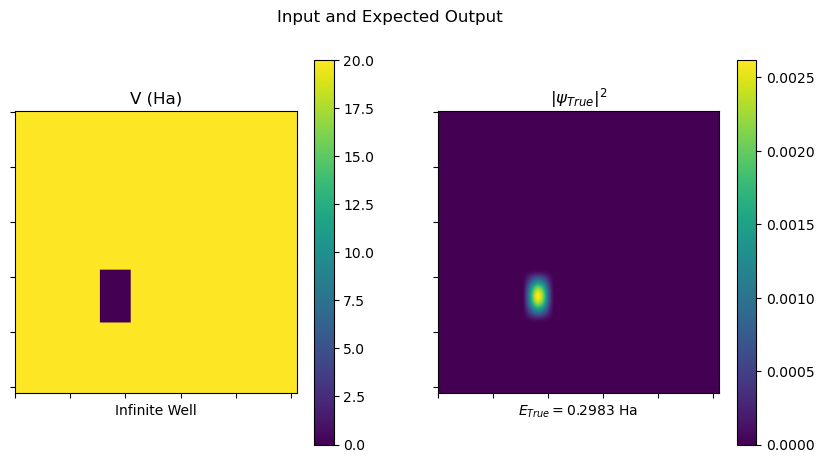

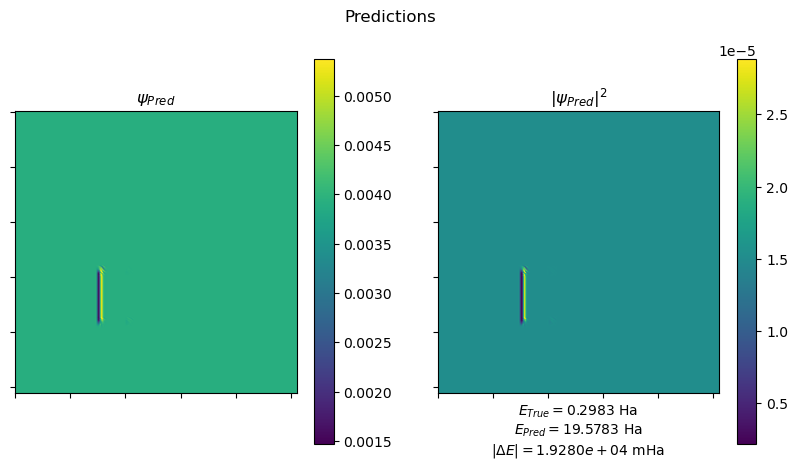

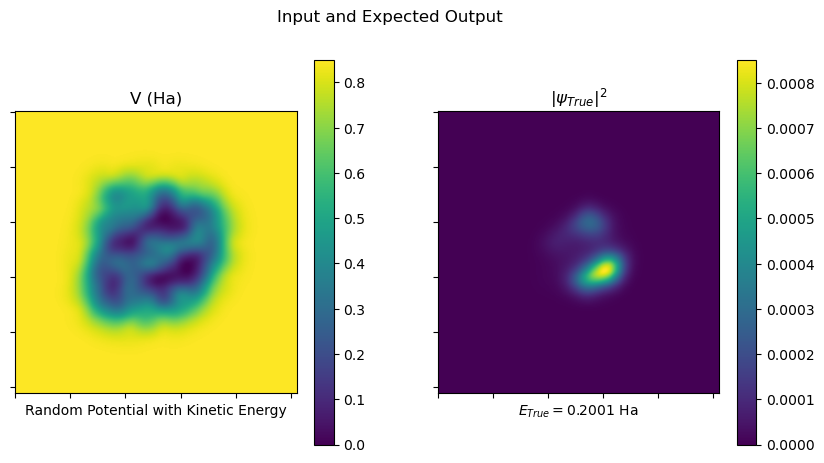

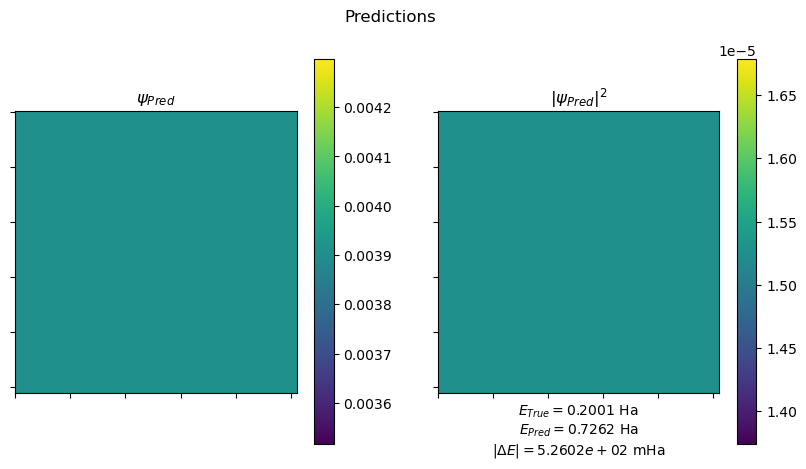

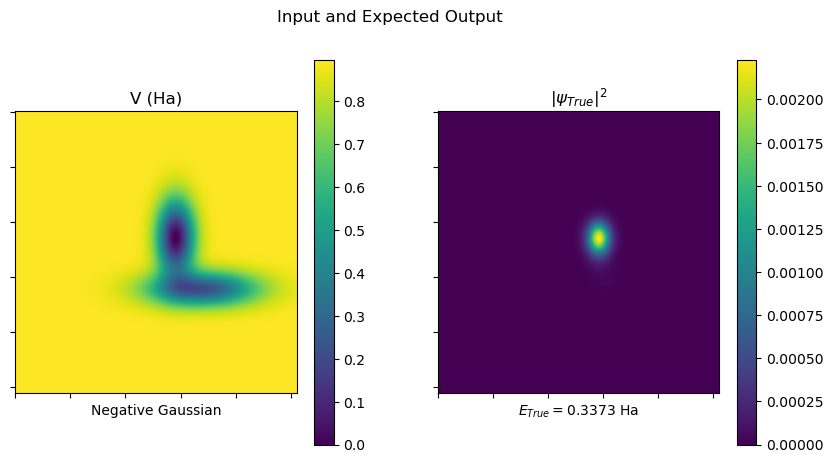

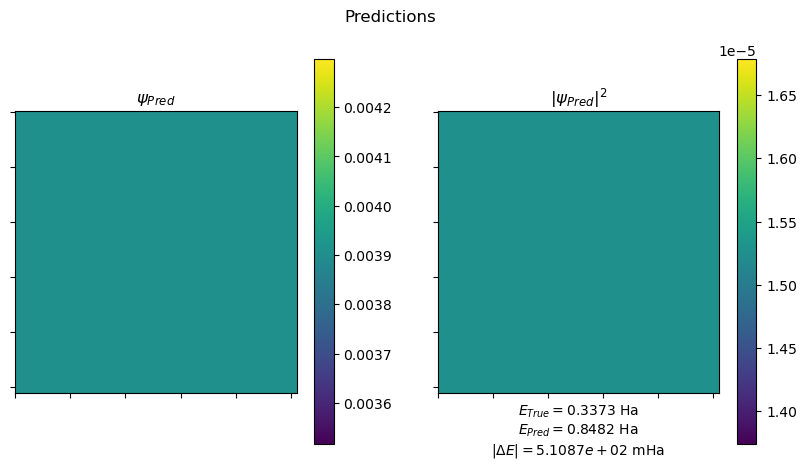

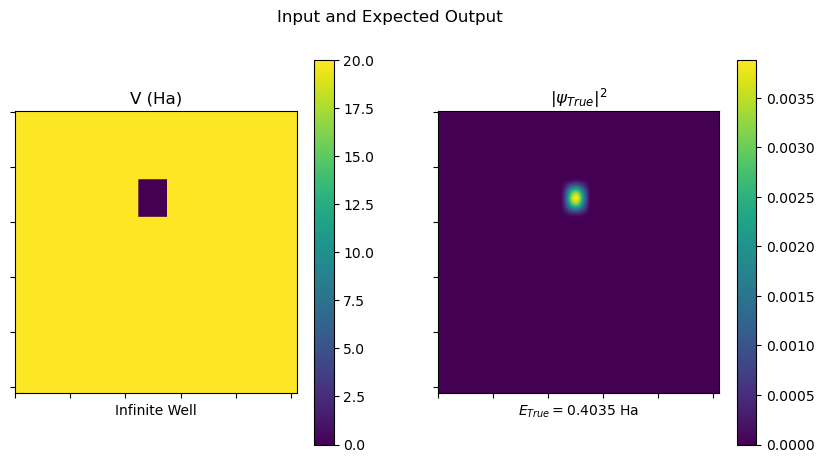

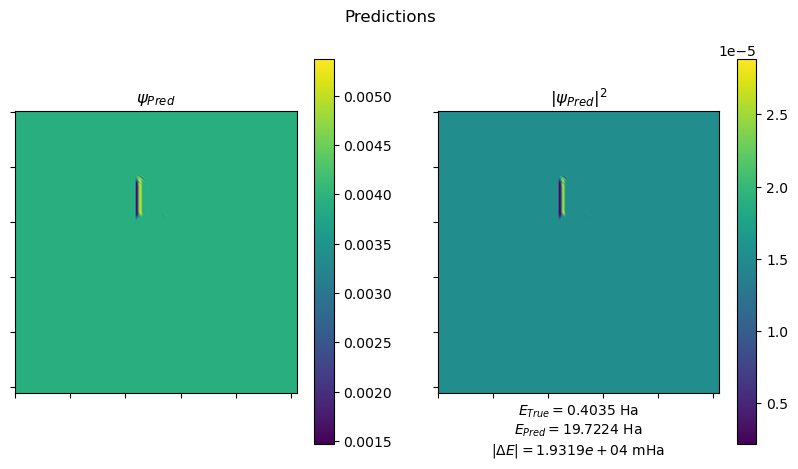

In [8]:
from HelperFunctions.print_image import print_img

limit = 5
model.eval()
for i, data in enumerate(presentation_dataloader):
    if i >= limit:
        break
    potential = data['potential'].to(device)
    wavefunction = data['wavefunction2'].to(device)
    energy = data['energy']
    potential_index = data['potential_index']
    with torch.inference_mode():
        wavefunction_guess = model.forward(potential)
        energy_guess = energy_loss_fn.get_energy(potential,wavefunction_guess)
        print_img(potential.squeeze(dim=0),wavefunction.squeeze(dim=0),'V (Ha)',rf'$|\psi_{{True}}|^2$','Input and Expected Output',energy=energy,potential_label=file_labels[potential_index.item()],energy_diff=True)
        print_img(wavefunction_guess.squeeze(dim=0),(wavefunction_guess**2).squeeze(dim=0),rf'$\psi_{{Pred}}$',rf'$|\psi_{{Pred}}|^2$','Predictions',energy=energy,energy_pred=energy_guess,energy_diff=True)